In [1]:
import pandas as pd
import numpy as np


In [2]:
training = pd.read_excel('training.xlsx')
scoring = pd.read_excel("scoring.xlsx")
californiaUtilityData = pd.read_excel("cailutility2.xlsx", sheet_name=2)

In [3]:
californiaUtilityData = californiaUtilityData.rename(columns={"year": "modelYear"})

# Data Wrangling: Preprocessing

Training Data Preprocessing

In [4]:
# Renaming columns to short-hand without spaces
training = training.rename(columns={
    'Date': 'year',
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    "Model Year": "modelYear",
    "Fuel Technology": "fuelTechnology",
    "Electric Mile Range": "electricMileRange",
    "Number of Vehicles Registered at the Same Address": "numVehiclesReg",
})

# Dropping column 'Region' as all values correspond to 'Statewide'
training = training.drop(columns=['Region'])

# Update missing values in Model Year to use mode from Fuel Type, Fuel Technology subcategories
mode_per_group = training.groupby(["fuelType", "fuelTechnology"])['modelYear'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
training['modelYear'] = training['modelYear'].fillna(mode_per_group)

# Update unknown values in Electric Mile Range to use mode from Date, Vehicle Category, Fuel Type, Fuel Technology subcategories
mode_electricMileRange = training.groupby(["year", "vehicleCategory", "fuelType", "fuelTechnology"])['electricMileRange'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
training['electricMileRange'] = training['electricMileRange'].where(training['electricMileRange'] != 'Unknown', mode_electricMileRange)

# Apply one-hot encoding to GVWR Class, Vehicle Category, Fuel Type, Fuel Technology, Electric Mile Range
training = pd.get_dummies(training,
                            columns=["gvwrClass", "vehicleCategory", "fuelType", "fuelTechnology", "electricMileRange"],
                            prefix=["gvwrClass", "vehicleCategory", "fuelType", "fuelTech", "electricMileRange"],
                            prefix_sep="_")

# Feature synthesis with extracting vehicle age from year of indutry and model year
training['vehicleAge'] = training['year'] - training['modelYear']

# Create ordinal encoder from numVehiclesReg
from sklearn.preprocessing import OrdinalEncoder
training['numVehiclesReg'] = training['numVehiclesReg'].astype(str)
ordinal_encoder = OrdinalEncoder(categories=[['Unknown', '1', '2', '3', '≥4']])
training['numVehiclesRegEncoded'] = ordinal_encoder.fit_transform(training[['numVehiclesReg']])
training = training.drop(columns=['numVehiclesReg'])

In [5]:
training

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,fuelTech_ICE,fuelTech_PHEV,electricMileRange_0 to 50 miles,electricMileRange_101 to 150 miles,electricMileRange_51 to 100 miles,electricMileRange_>150 miles,electricMileRange_Not Applicable,electricMileRange_Unknown,vehicleAge,numVehiclesRegEncoded
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,-1.0,4.0
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,0.0,1.0
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,1.0,1.0
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,0.0,4.0
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,36.0,1.0
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,39.0,2.0
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,41.0,3.0
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,43.0,2.0


In [6]:
trainingCali = pd.merge(training, californiaUtilityData, on="modelYear", how="left")

In [7]:
trainingCali

,year,modelYear,Vehicle Population,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,...,electricMileRange_51 to 100 miles,electricMileRange_>150 miles,electricMileRange_Not Applicable,electricMileRange_Unknown,vehicleAge,numVehiclesRegEncoded,Average of avgPriceGasolineUnleadedRegular,Average of avgGasPerThermUSD,Average of avgElecKWHUSD,Average of avgLowSulfurDieselUsdPerGallon
0,2019,2020.0,395883,False,False,False,False,False,False,False,...,False,False,True,False,-1.0,4.0,3.118000,1.615583,0.234917,3.118000
1,2020,2020.0,370954,False,False,False,False,False,False,False,...,False,False,True,False,0.0,1.0,3.118000,1.615583,0.234917,3.118000
2,2021,2020.0,349406,False,False,False,False,False,False,False,...,False,False,True,False,1.0,1.0,3.118000,1.615583,0.234917,3.118000
3,2019,2019.0,348475,False,False,False,False,False,False,False,...,False,False,True,False,0.0,4.0,3.705417,1.486333,0.217333,3.705417
4,2019,2018.0,333296,False,False,False,False,False,False,False,...,False,False,True,False,1.0,4.0,3.641833,1.449750,0.209750,3.641833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41048,2019,1983.0,1,False,False,False,False,False,False,False,...,False,False,True,False,36.0,1.0,1.291583,0.475667,0.076333,NaN
41049,2019,1980.0,1,False,False,False,False,False,False,False,...,False,False,True,False,39.0,2.0,1.309833,0.453833,0.067167,NaN
41050,2019,1978.0,1,False,False,False,False,False,False,False,...,False,False,True,False,41.0,3.0,0.716917,0.203000,0.041000,NaN
41051,2019,1976.0,1,False,False,False,False,False,False,False,...,False,False,True,False,43.0,2.0,NaN,NaN,NaN,NaN


Scoring Data Preprocessing

In [8]:
# Renaming columns to short-hand without spaces
scoring = scoring.rename(columns={
    'Date': 'year',
    'Vehicle Category': 'vehicleCategory',
    'GVWR Class': 'gvwrClass',
    'Fuel Type': 'fuelType',
    "Model Year": "modelYear",
    "Fuel Technology": "fuelTechnology",
    "Electric Mile Range": "electricMileRange",
    "Number of Vehicles Registered at the Same Address": "numVehiclesReg",
})

# Dropping column 'Region' as all values correspond to 'Statewide'
scoring = scoring.drop(columns=['Region'])

# Update missing values in Model Year to use mode from Fuel Type, Fuel Technology subcategories
mode_per_group_scoring = scoring.groupby(["fuelType", "fuelTechnology"])['modelYear'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
scoring['modelYear'] = scoring['modelYear'].fillna(mode_per_group_scoring)

# Update unknown values in Electric Mile Range to use mode from Date, Vehicle Category, Fuel Type, Fuel Technology subcategories
mode_electricMileRange_scoring = scoring.groupby(["year", "vehicleCategory", "fuelType", "fuelTechnology"])['electricMileRange'].transform(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else x)
scoring['electricMileRange'] = scoring['electricMileRange'].where(scoring['electricMileRange'] != 'Unknown', mode_electricMileRange_scoring)

# Apply one-hot encoding to GVWR Class, Vehicle Category, Fuel Type, Fuel Technology, Electric Mile Range
scoring = pd.get_dummies(scoring,
                            columns=["gvwrClass", "vehicleCategory", "fuelType", "fuelTechnology", "electricMileRange"],
                            prefix=["gvwrClass", "vehicleCategory", "fuelType", "fuelTech", "electricMileRange"],
                            prefix_sep="_")
#training = pd.merge(training, californiaUtilityData, on="modelYear", how="left")

# Feature synthesis with extracting vehicle age from year of indutry and model year
scoring['vehicleAge'] = scoring['year'] - scoring['modelYear']

# Create ordinal encoder from numVehiclesReg
from sklearn.preprocessing import OrdinalEncoder
scoring['numVehiclesReg'] = scoring['numVehiclesReg'].astype(str)
ordinal_encoder = OrdinalEncoder(categories=[['Unknown', '1', '2', '3', '≥4']])
scoring['numVehiclesRegEncoded'] = ordinal_encoder.fit_transform(scoring[['numVehiclesReg']])
scoring = scoring.drop(columns=['numVehiclesReg'])

if 'fuelType_Unknown' in training.columns and 'fuelType_Unknown' not in scoring.columns:
    scoring['fuelType_Unknown'] = 0

# Align ordering to fit training columns
scoring = scoring[training.columns]

y_scoring_actual = scoring['Vehicle Population']
scoring = scoring.drop(columns=['Vehicle Population'])

In [9]:
scoringCali = pd.merge(scoring, californiaUtilityData, on="modelYear", how="left")

In [10]:
scoring

,year,modelYear,gvwrClass_1,gvwrClass_2,gvwrClass_3,gvwrClass_4,gvwrClass_5,gvwrClass_6,gvwrClass_7,gvwrClass_8,...,fuelTech_ICE,fuelTech_PHEV,electricMileRange_0 to 50 miles,electricMileRange_101 to 150 miles,electricMileRange_51 to 100 miles,electricMileRange_>150 miles,electricMileRange_Not Applicable,electricMileRange_Unknown,vehicleAge,numVehiclesRegEncoded
0,2024,2020.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,4.0,4.0
1,2024,2021.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,3.0,4.0
2,2024,2022.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,2.0,4.0
3,2024,2024.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,0.0,4.0
4,2024,2023.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541,2024,1989.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,35.0,3.0
7542,2024,1988.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,36.0,2.0
7543,2024,1988.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,36.0,3.0
7544,2024,1987.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,True,False,37.0,2.0


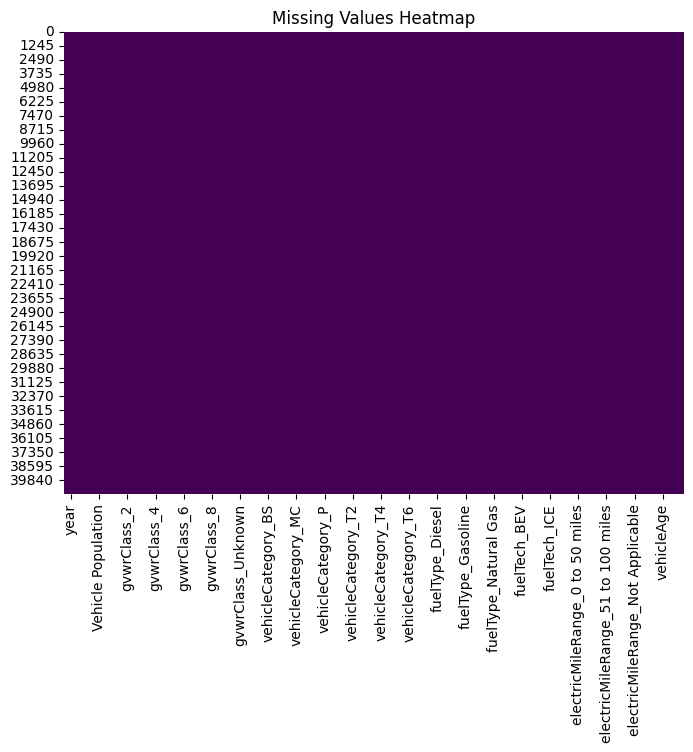

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(training.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

In [12]:
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [13]:
X = training.drop(columns=["Vehicle Population"])  # Features
y = training["Vehicle Population"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [14]:
from sklearn.linear_model import Ridge

# Train a Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Regularization strength

ridge_model.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge_model.predict(X_test)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge Regression RMSE: {rmse_ridge}")

mae = mean_absolute_error(y_test, y_pred_ridge)
print(f"Mean Absolute Error: {mae}")
r2 = r2_score(y_test, y_pred_ridge)
print(f"R-squared: {r2}")
mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Mean Squared Error: {mse}")

Ridge Regression RMSE: 17338.76123485272
Mean Absolute Error: 7245.4641902625835
R-squared: 0.1755549676267738
Mean Squared Error: 300632641.15923136


In [15]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.1)

lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"Lasso Regression RMSE: {rmse_lasso}")

mae = mean_absolute_error(y_test, y_pred_lasso)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred_lasso)
print(f"R-squared: {r2}")

mse = mean_squared_error(y_test, y_pred_lasso)
print(f"Mean Squared Error: {mse}")


Lasso Regression RMSE: 17338.924100665336
Mean Absolute Error: 7246.7435930425545
R-squared: 0.17553947926068292
Mean Squared Error: 300638288.96863323


C:\Users\ginap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+12, tolerance: 1.157e+09
  model = cd_fast.enet_coordinate_descent(


Bayesian Hyperparameter Optimization

In [16]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

# Define the optimization function for Bayesian Optimization
def lgb_eval(num_leaves, max_depth, learning_rate, n_estimators, min_child_samples, subsample, colsample_bytree, lambda_l1, lambda_l2, log_max_bin, reg_alpha,reg_lambda):
    # Set the LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'min_child_samples': int(min_child_samples),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'feature_pre_filter': False, # Disable feature pre-filtering
        'log_max_bin': log_max_bin,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
    }
    
    # Train the model without 'verbose' argument
    model = lgb.train(params, train_data, valid_sets=[valid_data],)
    
    # Predict and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Return the negative RMSE (since we are maximizing)
    return -rmse


# Set up the Bayesian Optimizer with wider ranges
optimizer = BayesianOptimization(
    f=lgb_eval, 
    pbounds={
        'num_leaves': (10, 200),  # Increased range
        'max_depth': (3, 25),      # Increased range
        'learning_rate': (0.001, 0.1),  # Increased range
        'n_estimators': (30, 500),  # Increased range
        'min_child_samples': (1, 100),  # Increased range
        'subsample': (0.4, 1.0),  # Increased range
        'colsample_bytree': (0.4, 1.0),  # Increased range
        'lambda_l1': (1e-6, 1e-2),  # Increased range
        'lambda_l2': (1e-6, 1e-2),  # Increased range
        'log_max_bin': (5,10), # Increased range
        'reg_alpha': (0.01,0.1),
        'reg_lambda': (0.1,0.5)

    },
    random_state=27
)

# Optimize the hyperparameters
#optimizer.maximize(init_points=10, n_iter=50)

# Print the best hyperparameters
#print("Best Hyperparameters: ", optimizer.max)


In [17]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': int(81.94562010166663),
    'max_depth': int(10.32559568840523),
    'learning_rate': 0.3,
    'n_estimators': int(117.14689484673896),
    'min_child_samples': int(9.787194938765415),
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
    'feature_pre_filter': False 
}
#best_params = optimizer.max['params']
bayes_2_params = {'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt', 
    'colsample_bytree': 1.0, 
    'lambda_l1': 0.01, 
    'lambda_l2': 0.01, 
    'learning_rate': 0.1, 
    'log_max_bin': 5.6680313827830195, 
    'max_depth': 14.946890466564938, 
    'min_child_samples': 23.90909213595021, 
    'n_estimators': 370.95179400495664, 
    'num_leaves': 173.00952498196241, 
    'reg_alpha': 0.01, 
    'reg_lambda': 0.1, 
    'subsample': 0.4}

bayes_2_params['n_estimators'] = int(bayes_2_params['n_estimators'])
bayes_2_params['max_depth'] = int(bayes_2_params['max_depth'])
bayes_2_params['min_child_samples'] = int(bayes_2_params['min_child_samples'])
bayes_2_params['num_leaves'] = int(bayes_2_params['num_leaves'])

best_params =  {'n_estimators': 484, 'num_leaves': 101, 'min_child_samples': 3, 'learning_rate': 0.028786855755827394, 'log_max_bin': 8, 'colsample_bytree': 0.989521951242629, 'reg_alpha': 0.02465352850408109, 'reg_lambda': 0.3846632019512515}

best_params['n_estimators'] = int(best_params['n_estimators'])
#best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_samples'] = int(best_params['min_child_samples'])
best_params['num_leaves'] = int(best_params['num_leaves'])



model = lgb.train(best_params, 
                  train_data, 
                  valid_sets=[valid_data],  
                  valid_names=["validation"],  
                  num_boost_round=1000,
                  )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

C:\Users\ginap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 32842, number of used features: 43
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3489.914682
RMSE: 1561.6487988425888
Mean Absolute Error: 351.3094090451149
R-squared: 0.9933120608007077
Mean Squared Error: 2438746.9709265004


In [18]:
y_scoring_pred = model.predict(scoring)

rmse = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_scoring_actual, y_scoring_pred)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_scoring_actual, y_scoring_pred)
print(f"R-squared: {r2}")

mse = mean_squared_error(y_scoring_actual, y_scoring_pred)
print(f"Mean Squared Error: {mse}")


RMSE: 3811.2227628686223
Mean Absolute Error: 624.1736495476075
R-squared: 0.961668465371838
Mean Squared Error: 14525418.948207935


C:\Users\ginap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


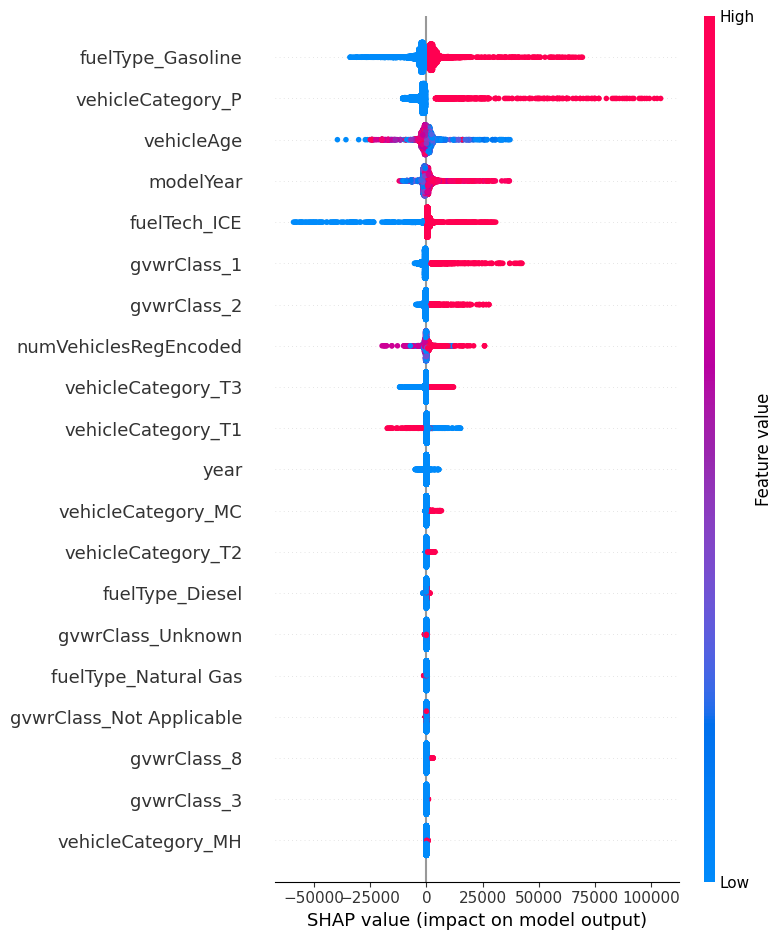

In [19]:
import shap
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(scoring)
shap.summary_plot(shap_values, scoring)

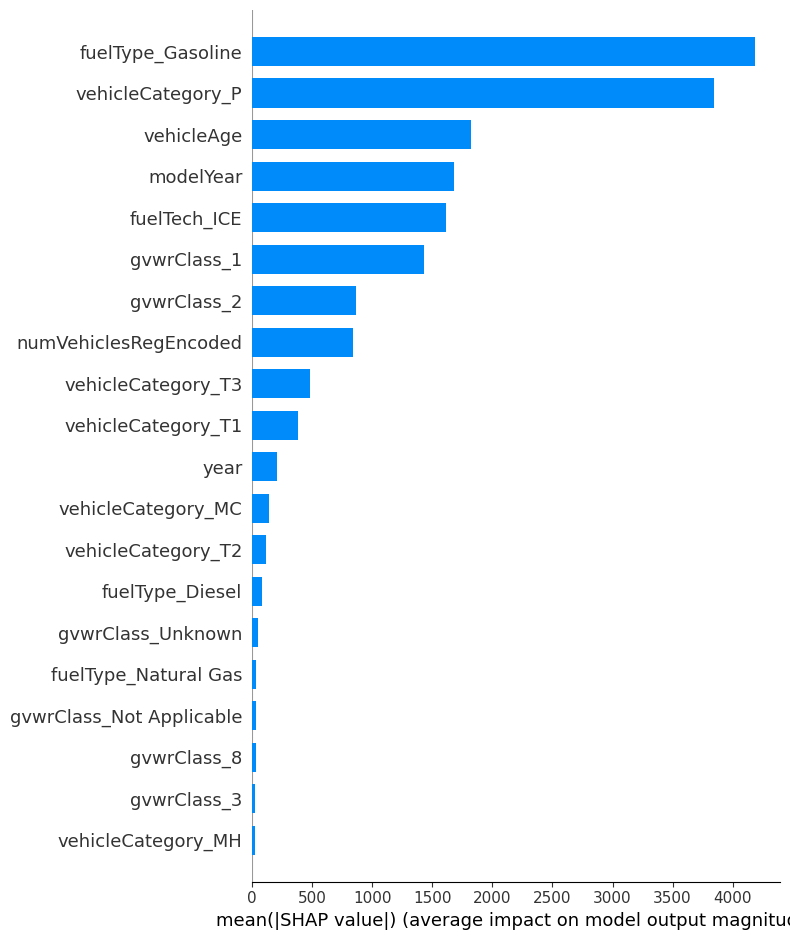

In [20]:
# Plot feature importance using the mean absolute SHAP value per feature
shap.summary_plot(shap_values, scoring, plot_type="bar")


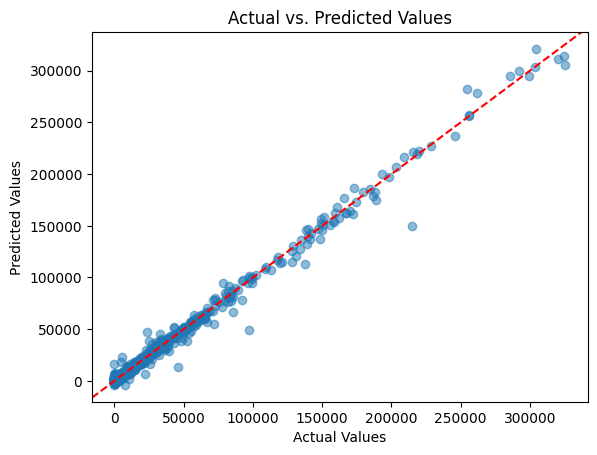

In [21]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.axline((0, 0), slope=1, color='red', linestyle='dashed') 
plt.show()


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

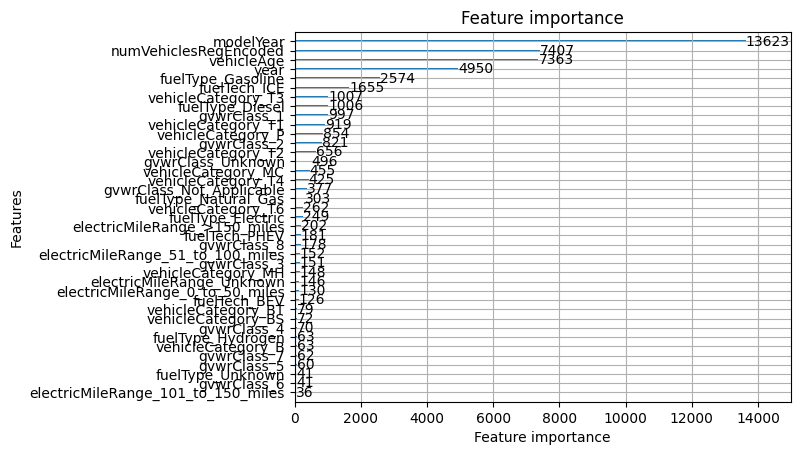

In [22]:
lgb.plot_importance(model)


<Figure size 3000x2000 with 0 Axes>

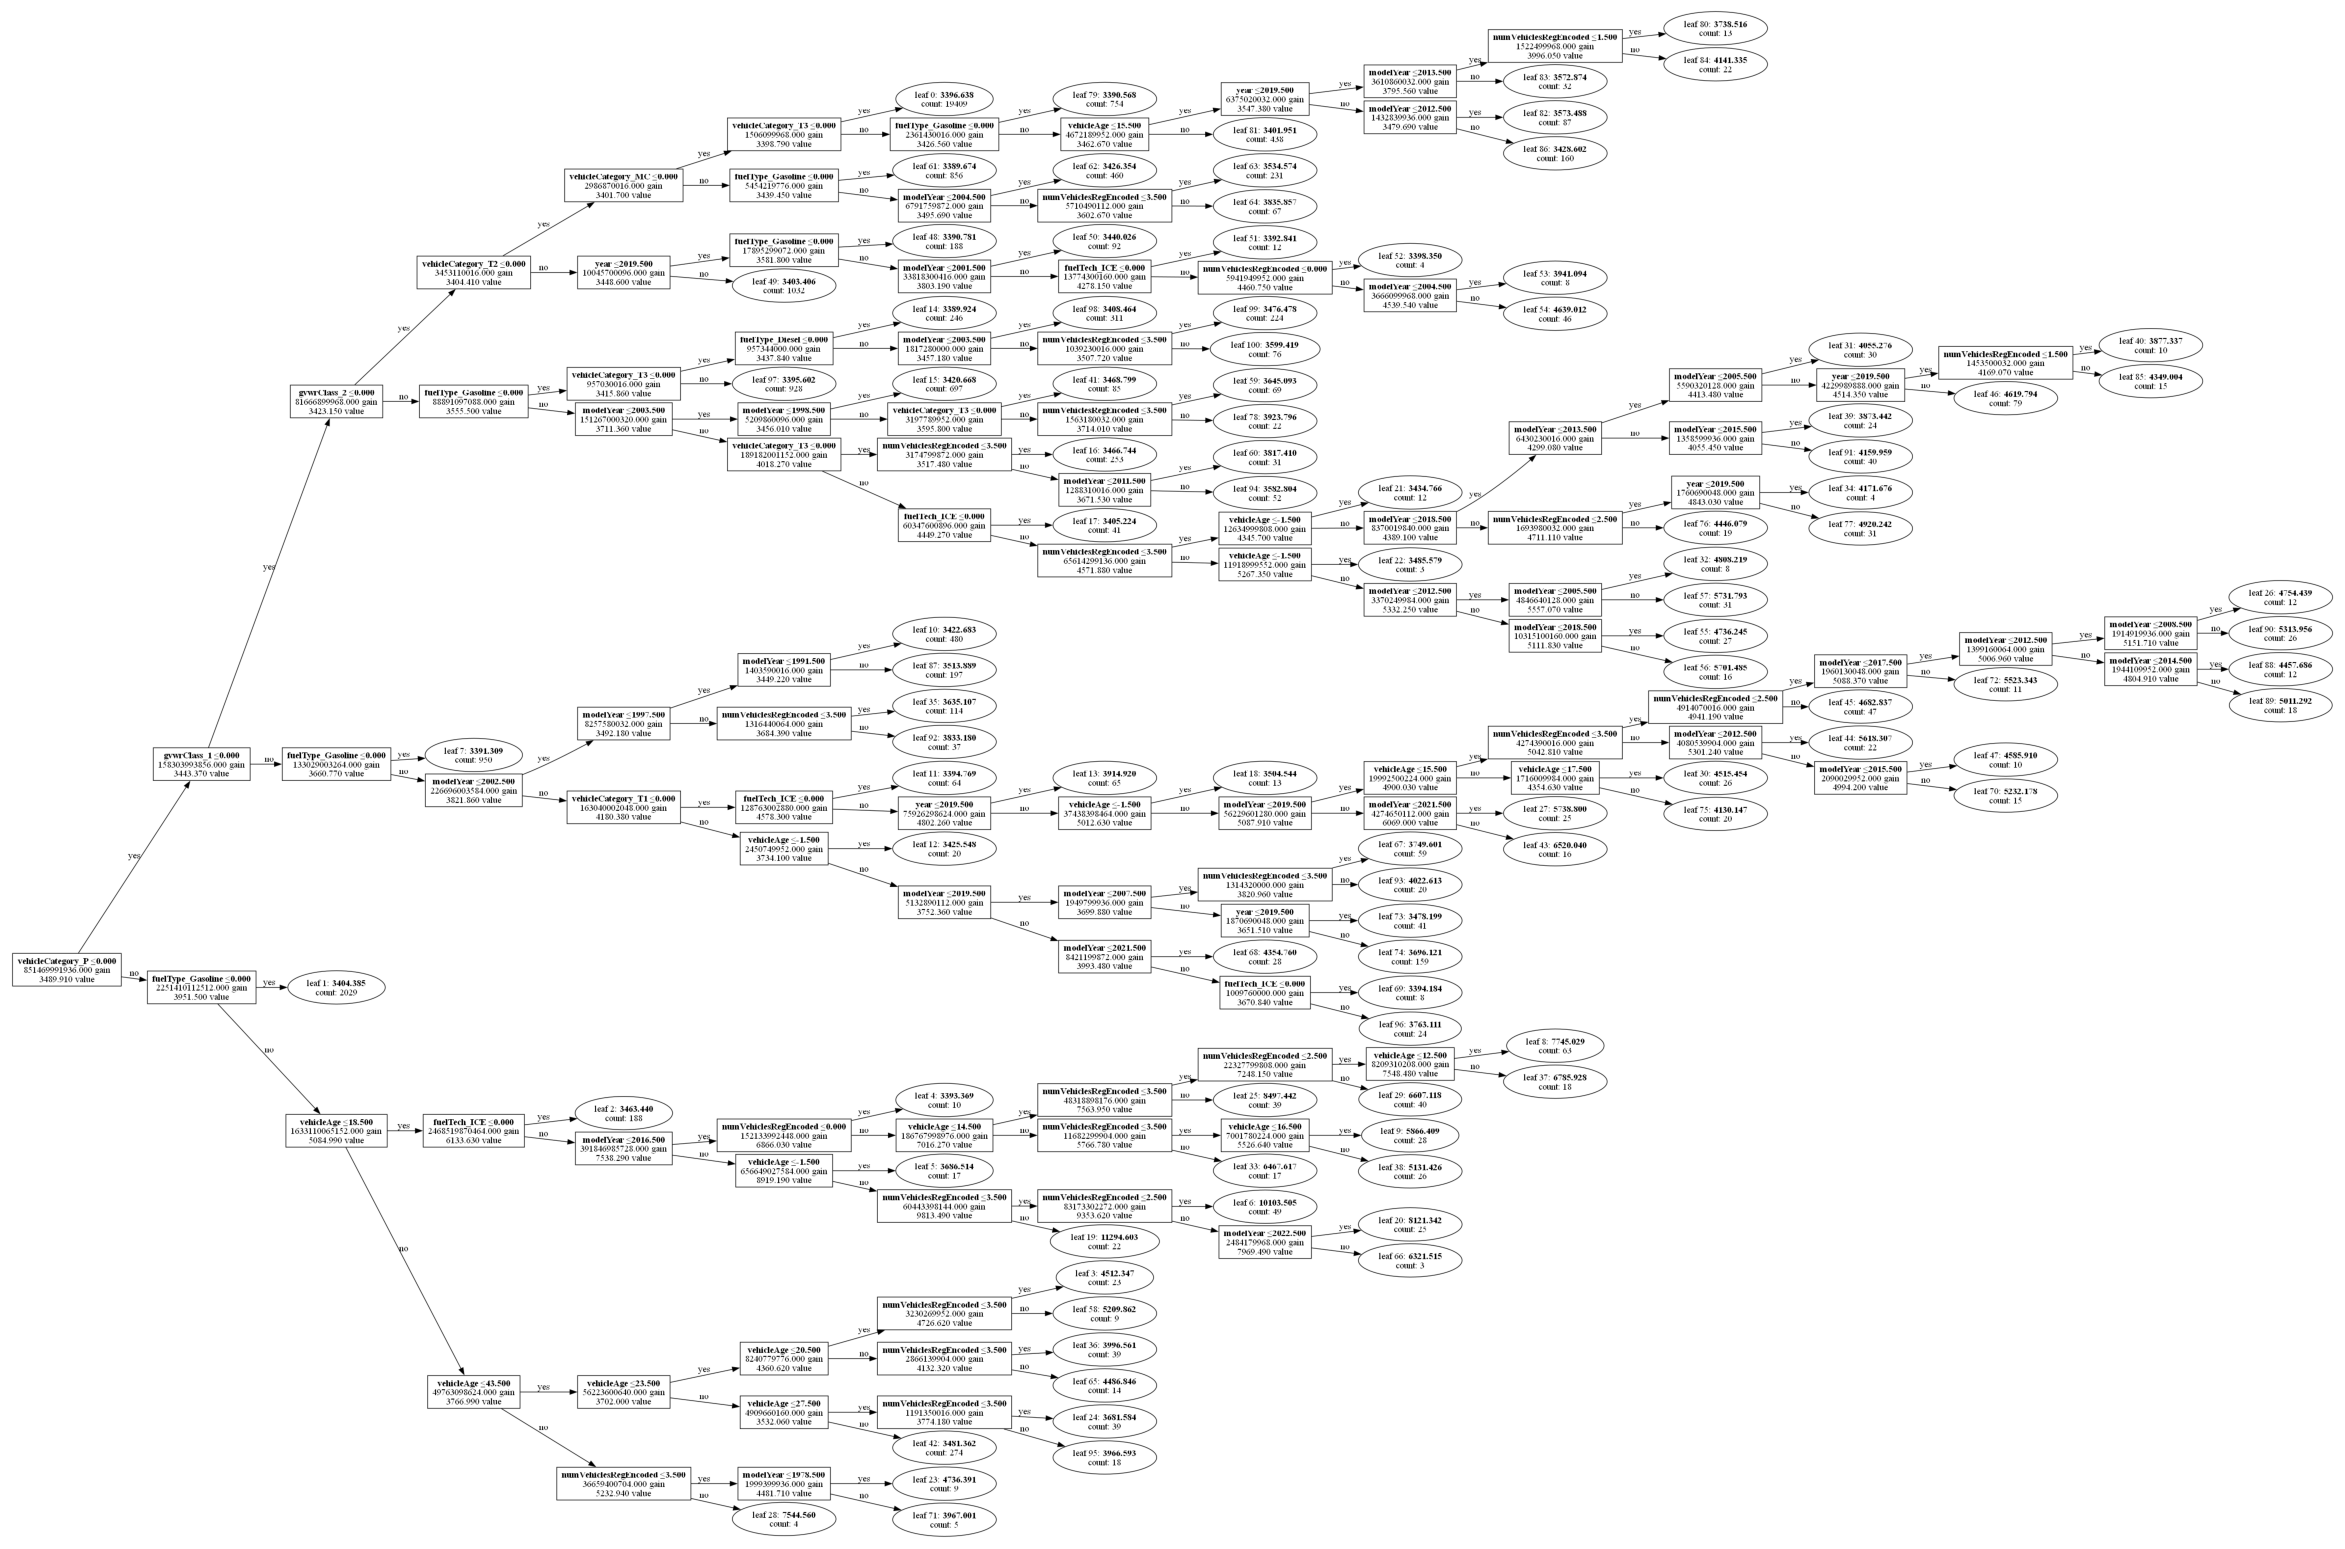

In [36]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Plot the tree, restricting the depth manually by specifying the nodes you want to show
plt.figure(figsize=(30, 20))
ax = lgb.plot_tree(model, tree_index=0, figsize=(30, 20), show_info=['split_gain', 'internal_value', 'leaf_count'])
plt.show()


In [24]:
print(training.columns)

Index(['year', 'modelYear', 'Vehicle Population', 'gvwrClass_1', 'gvwrClass_2',
       'gvwrClass_3', 'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6',
       'gvwrClass_7', 'gvwrClass_8', 'gvwrClass_Not Applicable',
       'gvwrClass_Unknown', 'vehicleCategory_B', 'vehicleCategory_BS',
       'vehicleCategory_BT', 'vehicleCategory_MC', 'vehicleCategory_MH',
       'vehicleCategory_P', 'vehicleCategory_T1', 'vehicleCategory_T2',
       'vehicleCategory_T3', 'vehicleCategory_T4', 'vehicleCategory_T5',
       'vehicleCategory_T6', 'vehicleCategory_T7', 'fuelType_Diesel',
       'fuelType_Electric', 'fuelType_Gasoline', 'fuelType_Hydrogen',
       'fuelType_Natural Gas', 'fuelType_Unknown', 'fuelTech_BEV',
       'fuelTech_FCEV', 'fuelTech_ICE', 'fuelTech_PHEV',
       'electricMileRange_0 to 50 miles', 'electricMileRange_101 to 150 miles',
       'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles',
       'electricMileRange_Not Applicable', 'electricMileRange_Unknown',
       

In [25]:
print(training.columns)

Index(['year', 'modelYear', 'Vehicle Population', 'gvwrClass_1', 'gvwrClass_2',
       'gvwrClass_3', 'gvwrClass_4', 'gvwrClass_5', 'gvwrClass_6',
       'gvwrClass_7', 'gvwrClass_8', 'gvwrClass_Not Applicable',
       'gvwrClass_Unknown', 'vehicleCategory_B', 'vehicleCategory_BS',
       'vehicleCategory_BT', 'vehicleCategory_MC', 'vehicleCategory_MH',
       'vehicleCategory_P', 'vehicleCategory_T1', 'vehicleCategory_T2',
       'vehicleCategory_T3', 'vehicleCategory_T4', 'vehicleCategory_T5',
       'vehicleCategory_T6', 'vehicleCategory_T7', 'fuelType_Diesel',
       'fuelType_Electric', 'fuelType_Gasoline', 'fuelType_Hydrogen',
       'fuelType_Natural Gas', 'fuelType_Unknown', 'fuelTech_BEV',
       'fuelTech_FCEV', 'fuelTech_ICE', 'fuelTech_PHEV',
       'electricMileRange_0 to 50 miles', 'electricMileRange_101 to 150 miles',
       'electricMileRange_51 to 100 miles', 'electricMileRange_>150 miles',
       'electricMileRange_Not Applicable', 'electricMileRange_Unknown',
       

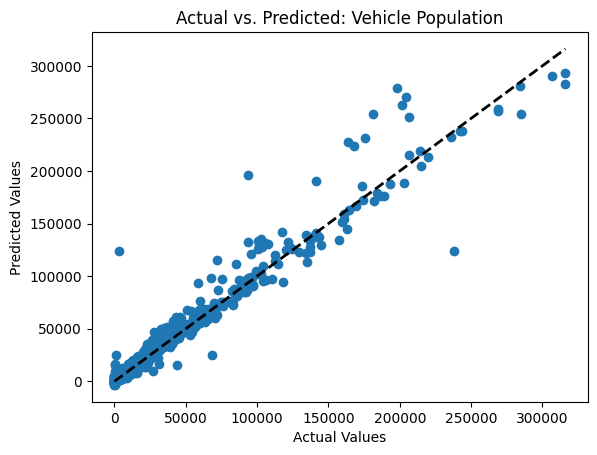

In [26]:
plt.scatter(y_scoring_actual, y_scoring_pred)
plt.plot([min(y_scoring_actual), max(y_scoring_actual)],
         [min(y_scoring_actual), max(y_scoring_actual)], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted: Vehicle Population')
plt.show()


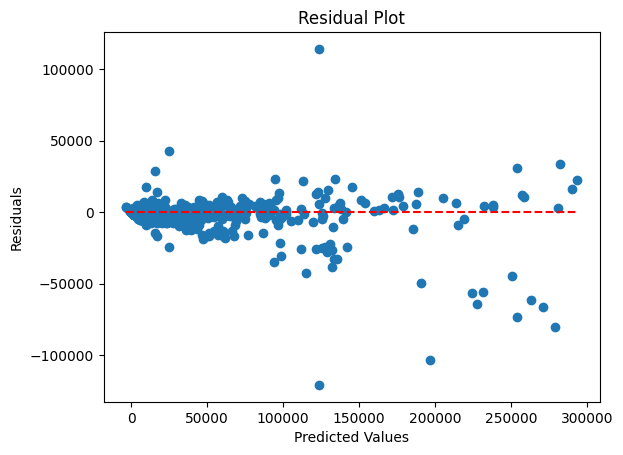

In [27]:
residuals = y_scoring_actual - y_scoring_pred

plt.scatter(y_scoring_pred, residuals)
plt.hlines(y=0, xmin=min(y_scoring_pred), xmax=max(y_scoring_pred), colors='r', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


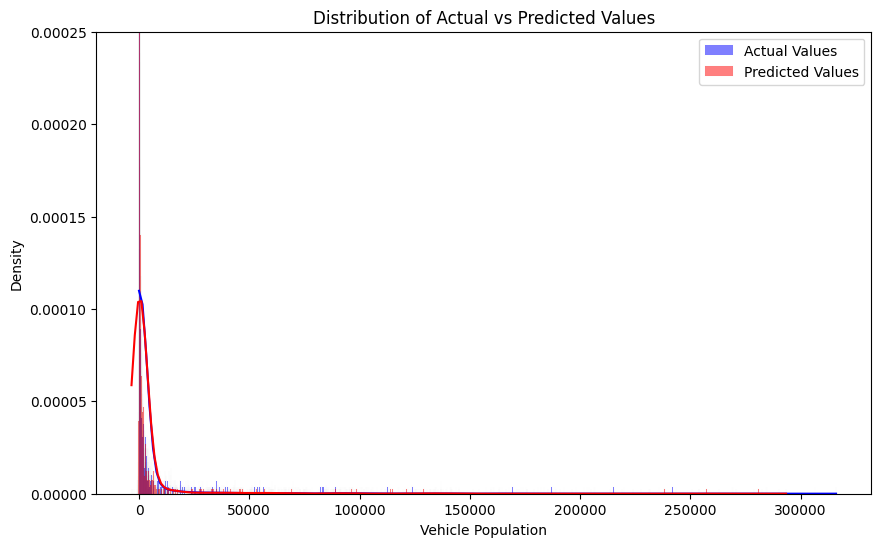

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(y_scoring_actual, color='blue', kde=True, label='Actual Values', stat='density')
sns.histplot(y_scoring_pred, color='red', kde=True, label='Predicted Values', stat='density')
plt.legend()
plt.title('Distribution of Actual vs Predicted Values')
plt.ylim(0, 0.00025)
plt.show()


In [29]:
X = trainingCali.drop(columns=["Vehicle Population"])  # Features
y = trainingCali["Vehicle Population"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)


In [30]:
y_test.shape

(8211,)

In [31]:
cali_model = lgb.train(best_params, 
                  train_data, 
                  valid_sets=[valid_data],  
                  valid_names=["validation"],  
                  num_boost_round=1000,
                  )


y_pred_cali = cali_model.predict(X_test, num_iteration=cali_model.best_iteration)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_cali))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_test, y_pred_cali)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_test, y_pred_cali)
print(f"R-squared: {r2}")

mse = mean_squared_error(y_test, y_pred_cali)
print(f"Mean Squared Error: {mse}")

C:\Users\ginap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 32842, number of used features: 47
[LightGBM] [Warning] Unknown parameter: log_max_bin
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3489.914682
RMSE: 1954.9969818874115
Mean Absolute Error: 379.9861288049386
R-squared: 0.9895186371526862
Mean Squared Error: 3822013.199188888


In [32]:
y_scoring_pred_cali = cali_model.predict(scoringCali)

rmse = np.sqrt(mean_squared_error(y_scoring_actual, y_scoring_pred_cali))
print(f"RMSE: {rmse}")

mae = mean_absolute_error(y_scoring_actual, y_scoring_pred_cali)
print(f"Mean Absolute Error: {mae}")

r2 = r2_score(y_scoring_actual, y_scoring_pred_cali)
print(f"R-squared: {r2}")

mse = mean_squared_error(y_scoring_actual, y_scoring_pred_cali)
print(f"Mean Squared Error: {mse}")


RMSE: 5031.895740877013
Mean Absolute Error: 735.1151002813465
R-squared: 0.9331824099351906
Mean Squared Error: 25319974.747056223
